In [1]:
%matplotlib notebook

# 4) IFU spatial masking

In this tutorial, we perform a pre-analysis of an IFU (Integral Field Unit) cube. These data sets provide both spatial and spectroscopic information of astronomical bodies. You can download this tutorial as a [python script](https://github.com/Vital-Fernandez/lime/blob/master/examples/example4_IFU_masking.py) or a [jupyter notebook](https://github.com/Vital-Fernandez/lime/blob/master/docs/source/tutorials/4_IFU_Spatial_Masking.ipynb).


The workflow for an IFU observation is very similar to the one we saw in the previous tutorials for long-slit spectra. However, in order to preserve the spatial information and to maximise the quality of the measurements, it is recommended to use spatial masks. These provide two advantages:
* In most cases, the scientific data does not cover full IFU field of view. To maximise your time and the computational resources, the non-scientific/noisy regions should be excluded from the analysis.
* In resolved observations, the phenomena responsible for the observed radiation do not remain constant. This means that the properties of the emission lines can vary dramatically in a few spaxels. Consequently, your fittings should adapt to this spatial behaviour. Binary masks provide the means to personalise $LiMe$ fittings.

Let’s start by downloading one IFU data cube from the [MANGA survey](https://www.sdss4.org/surveys/manga/). In this tutorial, we will analyze [SHOC579](https://dr17.sdss.org/marvin/galaxy/8626-12704/), a compact galaxy with an intense star forming region:

<img src="https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/8626/images/12704.png" alt="Image showing the bands selection for a line" title="Bands for the H1_3889A line"/>


In [2]:
# This try import is only necessary for the developper to compile the online documentation from this notebook
try:
    import lime
except ImportError:
    import sys
    sys.path.append('../../../src')

import lime
import urllib.request
from astropy.io import fits
from pathlib import Path
from astropy.wcs import WCS
from sys import stdout

In [3]:
# Web address and save file location
cube_url = 'https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/8626/stack/manga-8626-12704-LOGCUBE.fits.gz'
cube_address = Path('./sample_data/manga-8626-12704-LOGCUBE.fits.gz')


The following command will download the IFU datacube if it isn't already in the ``sample_data`` folder. This may take some time. To keep a better track of the process you can use the ``cube_url`` [web link](https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/8626/stack/manga-8626-12704-LOGCUBE.fits.gz) to manually download the cube and place it on the ``sample_data`` folder,

In [4]:
# Function to display the download progress on the terminal
def progress_bar(count, block_size, total_size):
    percent = int(count * block_size * 100 / total_size)
    stdout.write("\rDownloading...%d%%" % percent)
    stdout.flush()

# Download the cube file if not available (this may take some time)
if cube_address.is_file() is not True:
    urllib.request.urlretrieve(cube_url, cube_address, reporthook=progress_bar)
    print(" Download complete!")
else:
    print('Observation found in folder')

Observation found in folder


We proceed to load the configuration file and observation data 

In [5]:
# Load the configuration file:
cfgFile = './sample_data/manga.cfg'
obs_cfg = lime.load_cfg(cfgFile)

# Observation properties
z_obj = obs_cfg['SHOC579']['redshift']
norm_flux = obs_cfg['SHOC579']['norm_flux']

# Open the MANGA cube fits file
with fits.open(cube_address) as hdul:
    wave = hdul['WAVE'].data
    flux_cube = hdul['FLUX'].data * norm_flux
    hdr = hdul['FLUX'].header

$LiMe$ includes several tools to display IFU data. To include the spatial coordinates on these plots you need to import the World Coordinates System [WCS](https://fits.gsfc.nasa.gov/fits_wcs.html) from your *.fits* file header. This can be done using [astropy WCS class](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html):


In [6]:
# Declaring the world coordinate system from the header to display on the plots
wcs = WCS(hdr)

a string value was expected. [astropy.wcs.wcs]


At this point we can define a $LiMe$ ``Cube`` object for our observation:


In [7]:
# Define a LiMe cube object
shoc579 = lime.Cube(wave, flux_cube, redshift=z_obj, norm_flux=norm_flux)

From this object, we can access the functions to fit and plot the data. For example, we can use the ``.plot.cube`` to spatially plot a spectral band:

<IPython.core.display.Javascript object>


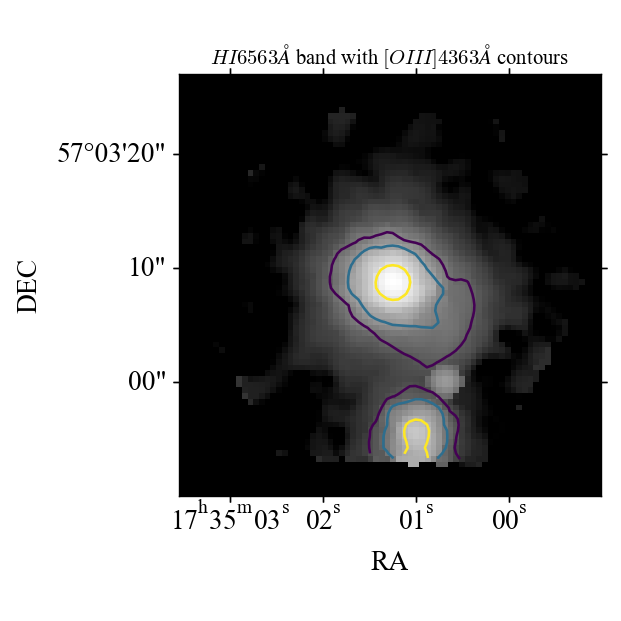

S:\anaconda3\envs\lime\lib\site-packages\astropy\visualization\wcsaxes\core.py:254: UserWarning: Log scale: values of z <= 0 have been masked
  cset = super().contour(*args, **kwargs)


In [8]:
# Check the spaxels interactively
shoc579.plot.cube(6563, line_fg=4363, wcs=wcs)

In the previous function the first argument (``line``) specifies the band for the plot background. Since we did not specify a ``band`` wavelength interval, $LiMe$ will get the band from the closest transition on the default database (in this case $H\alpha$). The user can also specify a ``percentile_bg`` for the lowest flux limit. For example:

<IPython.core.display.Javascript object>


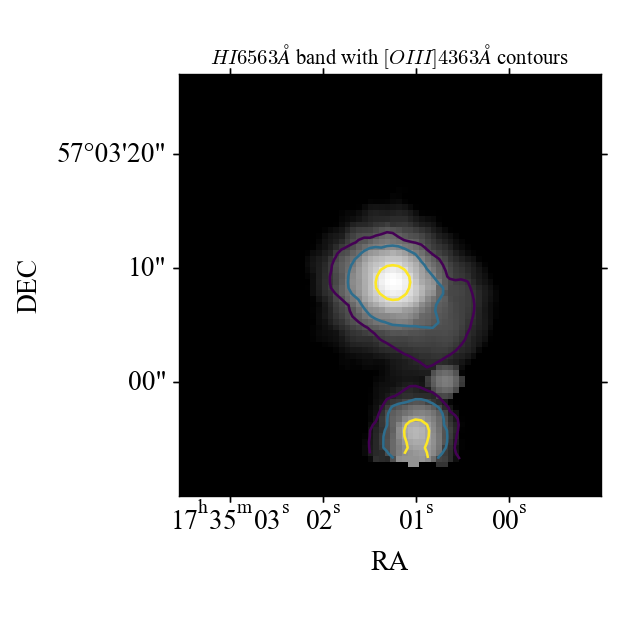

S:\anaconda3\envs\lime\lib\site-packages\astropy\visualization\wcsaxes\core.py:254: UserWarning: Log scale: values of z <= 0 have been masked
  cset = super().contour(*args, **kwargs)


In [9]:
shoc579.plot.cube('H1_6563A', line_fg=4363, wcs=wcs, percentile_bg=80)

The ``line_fg`` argument allows the user to specify a band for the intensity contours. In the previous commands, we used the $[OIII]4363Å$ temperature diagnostic line.

To specify the number of contours, the user can provide a list percentiles with the ``percentiles_fg`` argument for the flux limits:

<IPython.core.display.Javascript object>


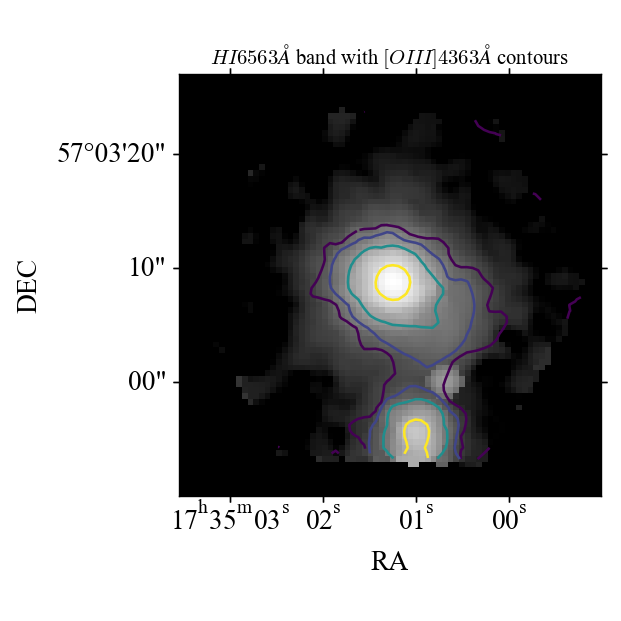

S:\anaconda3\envs\lime\lib\site-packages\astropy\visualization\wcsaxes\core.py:254: UserWarning: Log scale: values of z <= 0 have been masked
  cset = super().contour(*args, **kwargs)


In [10]:
shoc579.plot.cube('H1_6563A', line_fg='O3_4363A', wcs=wcs, percentiles_fg=(85, 90, 95, 99))

From these contours, you are likely to conclude that there are two star-forming clusters. You should, however, inspect the spaxels spectra on these regions. You can do that with the ``.check.cube`` function:

<IPython.core.display.Javascript object>


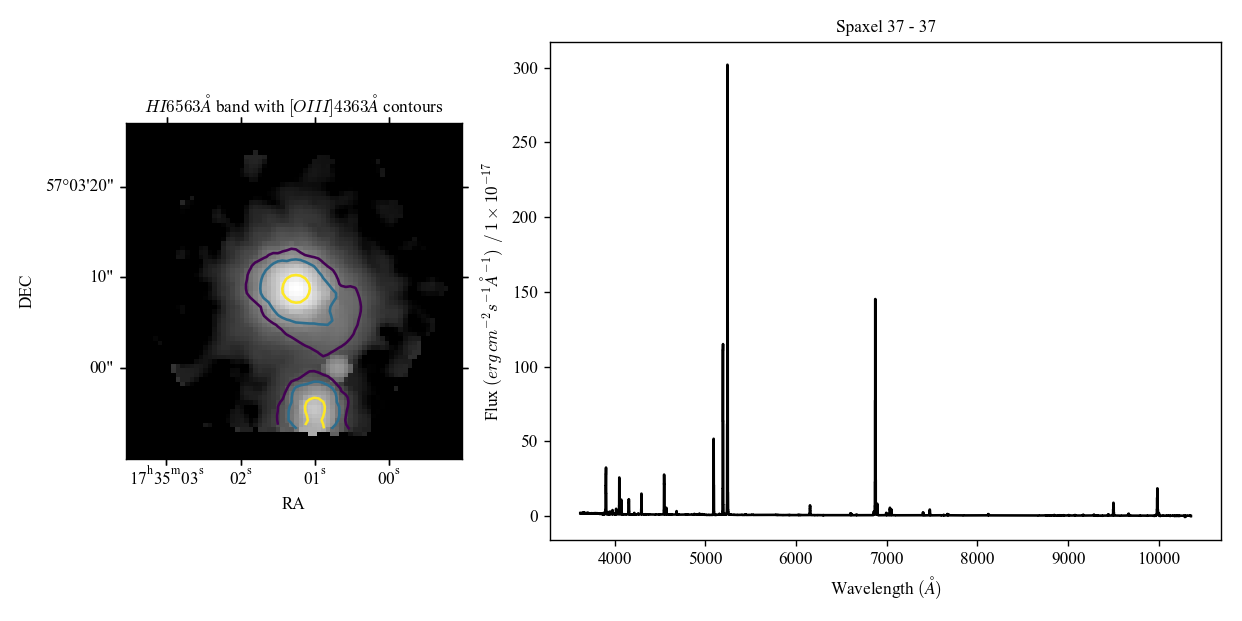

S:\anaconda3\envs\lime\lib\site-packages\astropy\visualization\wcsaxes\core.py:254: UserWarning: Log scale: values of z <= 0 have been masked
  cset = super().contour(*args, **kwargs)


In [11]:
# Manually add/remove spaxels to the spatial mask
shoc579.check.cube('H1_6563A', line_fg='O3_4363A', wcs=wcs)

On the right-hand side of the new plot, you have the spectrum corresponding to the spaxel with the <span style="color:red">red cross</span>. You can change the active spaxel with a right-clik on the left-hand side plot. 

Inspecting the lower region on the IFU field of view, this radiation does not correspond to SHOC579 but a star. Consequently, the flux percentiles in this region are not mapping the ionized emission from the $[OIII]4363Å$ transition but the continuum from a nearby stellar atmosphere.

For a more detailed analysis, we can use the ``.spatial_masker`` to generate a binary mask. By default, these masks are generated based in the bands flux intensity (as in the case of the ``.plot.cube``). However, we can specify an emission signal-to-noise to compute this mask: 

In [12]:
# Generate a spatial mask as a function of the band flux
# Generate a spatial mask as a function of the signal to noise
spatial_mask = './sample_data/SHOC579_mask.fits'
shoc579.spatial_masker('O3_4363A', param='SN_line', percentiles=[93, 96, 99], output_address=spatial_mask, header_dict=hdr)

D:\Pycharm Projects\lime\docs\source\tutorials\../../../src\lime\treatment.py:667: RuntimeWarning: invalid value encountered in true_divide
  param_image = (np.sqrt(2 * n_pixels * np.pi) / 6) * (Amp_image / std_image)


We can visualize this mask using the ``.plot.cube`` function:

<IPython.core.display.Javascript object>


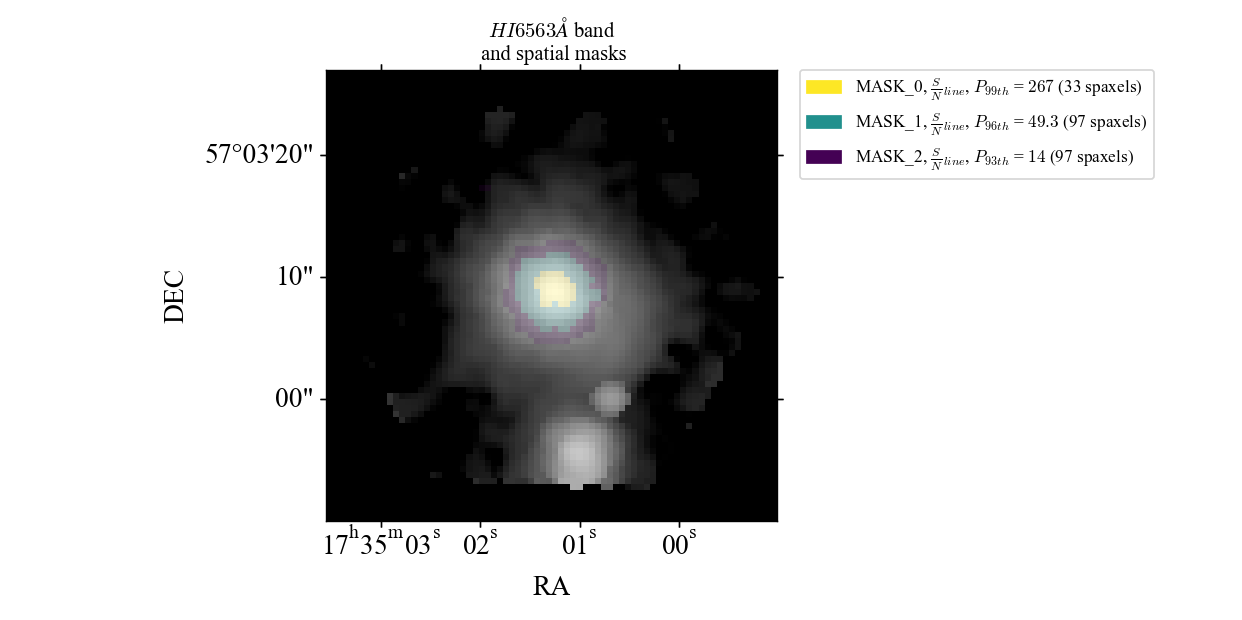

In [13]:
shoc579.plot.cube('H1_6563A', masks_file=spatial_mask, wcs=wcs)

Using this criterium, the masks are now constrained to the star-forming burst. You can adjust the mapping and number of masks using the ``percentiles`` argument. In some cases, however, this is not enough. For a more meticulous analysis, you can load this mask with the ``.check.cube`` function:

<IPython.core.display.Javascript object>


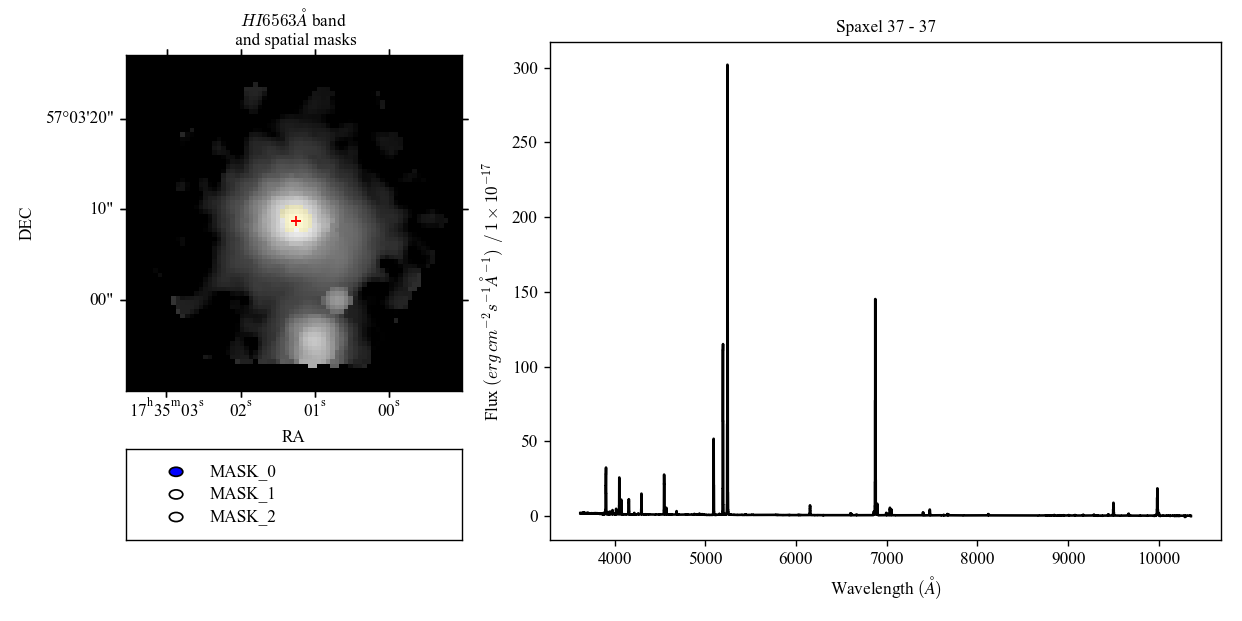

In [14]:
# Manually add/remove spaxels to the spatial mask
shoc579.check.cube('H1_6563A', masks_file=spatial_mask, wcs=wcs)

In the new plot, you can can select the masks available within the ``spatial_mask`` file we generated before. If you left double-click on a spaxel it will be added to the current mask if it was not (by default this spaxel will be removed from its previous mask). Otherwise, if the spaxel was already on the current mask, it will be removed from the selection.

You can use this manual selection, for example, to generate masks with certain lines o profiles. This will be very usefull for the fittings in the next tutorial.